In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# create a session
session = Session(engine)

In [11]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
# Get a list of column names and types - measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# View of data - station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [26]:
# Total dates
all_dates, = session.query(func.count(Measurement.date)).all() 
print(all_dates[0])

19550


In [27]:
# Latest date
latest_date, = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all() 
print(latest_date[0])

2017-08-23


In [105]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= '2016-08-23').\
                order_by(Measurement.date).all()



In [91]:
# Load the data from the query into a dataframe
data_df = pd.DataFrame(data)
data_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [92]:
# Reset the index to the date
data_df.set_index('date').head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


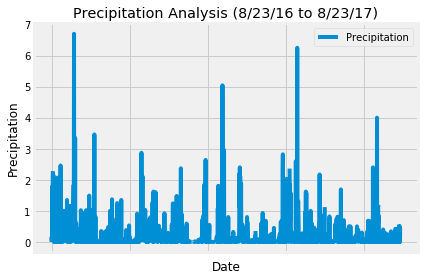

In [93]:
# Use Pandas Plotting with Matplotlib to plot the data
data_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation Analysis (8/23/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Precipitation Analysis.png")
plt.show()

# Exploratory Climate Analysis

In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [43]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [100]:
#Design a query to find the most active stations.

# List the stations and observation counts in descending order.
stations_activity = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
stations_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [101]:
# Which station has the highest number of observations?
most_active_station = stations_activity[0][0]
print(f"Most active station is {most_active_station} station with {stations_activity[0][1]} observations.")

Most active station is USC00519281 station with 2772 observations.


In [113]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
station_measurements = session.query(*sel).\
    filter(Measurement.station == most_active_station).\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()
station_measurements

[(54.0, 85.0, 71.66378066378067)]

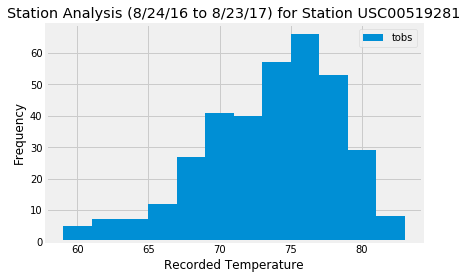

In [118]:
# Choose the station with the highest number of temperature observations.
data1 = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                filter(Measurement.date >= '2016-08-23').\
                filter(Measurement.station == most_active_station).\
                order_by(Measurement.date).all()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram with bins=12
data1_df=pd.DataFrame(data1)
plt.hist(data1_df['tobs'],12)
plt.legend(["tobs"])
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + most_active_station)
plt.savefig("Station Analysis.png")
plt.show()


In [119]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [129]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

arrive = dt.date(2012, 2, 28)
depart = dt.date(2012, 3, 5)
last_year_arrival = dt.date(2012, 2, 28)-dt.timedelta(days=365)
last_year_depart = dt.date(2012, 3, 5)-dt.timedelta(days=365)
last_year_temp = (calc_temps((last_year_arrival), (last_year_depart)))
print(last_year_temp)


[(61.0, 70.08928571428571, 75.0)]


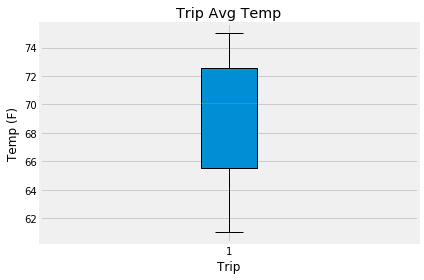

In [132]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
x = range(len(last_year_temp))
ax.boxplot(last_year_temp, patch_artist=True)
ax.set_title('Trip Avg Temp')
ax.set_ylabel("Temp (F)")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.savefig ("Trip Avg Temp.png")
plt.show()


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


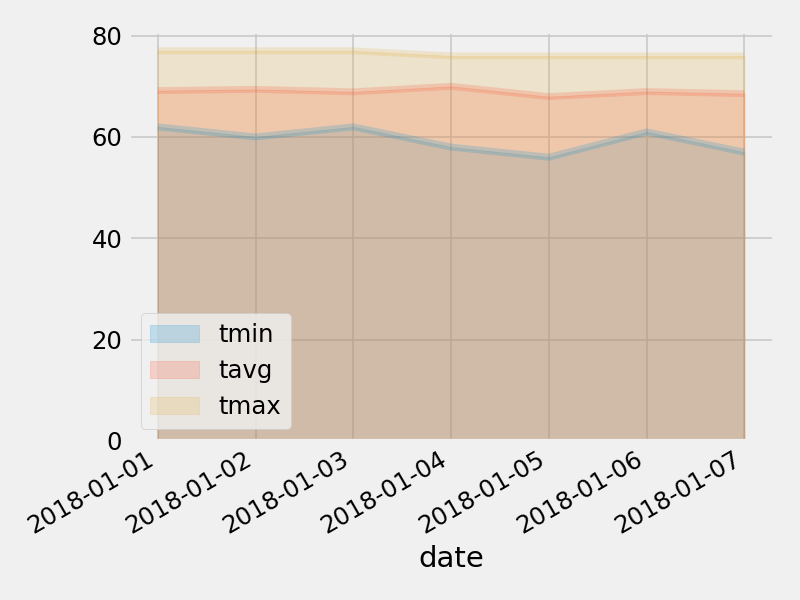

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
